# Training classifiers on Jae's dataset

In [2]:
import numpy as np
import pandas as pd

We'll read in Jae's data, which is contained in `data/test_02.xlsx`.  Using `read_excel` with `sheet_name = None` will read in all of the sheets as a dictionary whose keys are the sheet names and the values are data frames containing the data in that sheet. 

In [3]:
algal_bloom_data = pd.read_excel('data/test_02.xlsx', sheet_name = None)
algal_bloom_data.keys()

odict_keys(['Sheet1', 'Sheet2', 'Sheet4', '1-wk ahead', 'example'])



## Data preparation

The data set we'll be working with is in the `example` sheet of `sample_algal_bloom_data`:

In [46]:
sample_algal_bloom_data = algal_bloom_data['1-wk ahead']
sample_algal_bloom_data.head()

,Tox_class,Ecoli,pH,DOC,TKP,TKN,NP.ratio,NH3,Nox,NO2,Cl,SO4,16S,mcyAM,mcyAA,mcyAP
0,1,7300,8.10,5.848,1.609,0.660,0.410193,0.024000,0.018,NaN,18.760,21.602,147000,0,0,0
1,1,1100,7.85,7.288,1.382,0.458,0.331404,0.032695,15.163,0.0707,20.334,21.095,1760000,0,0,0
2,1,140,8.01,1.694,1.327,0.423,0.318764,0.085000,13.012,0.0603,21.218,22.536,2190000,0,0,0
3,1,1500,7.28,2.583,1.217,0.569,0.467543,0.083000,15.872,0.0592,19.018,21.775,4440000,0,0,0
4,1,3400,8.80,1.450,1.056,0.517,0.489583,0.149000,10.882,0.0563,19.203,26.198,423,0,0,0


Each row in `sample_algal_bloom_data` contains the measurements of different chemicals taken at a particular timepoint. `Tox_class` is the classification of the water into toxicity class based on the measurements in the other columns.  Our goal is to train a classifier to predict the toxicity class based on the other readings. 

The first classifier we'll be using is the random forest classifier.  Since random forests can't handle missing data, we'll first check to see if our data set has any missing data:

In [28]:
sample_algal_bloom_data.isnull().values.any()

True

We'll fill in the missing values before we do any analysis.  We'll first use the `Imputer` class from `sklearn.preprocessing`:

In [44]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values = "NaN", strategy = 'mean', axis = 0)
imp.fit(sample_algal_bloom_data)
imputed_data = pd.DataFrame(imp.fit_transform(sample_algal_bloom_data))
imputed_data.columns = sample_algal_bloom_data.columns
imputed_data.head()

,Tox_class,Ecoli,pH,DOC,TKP,TKN,NP.ratio,NH3,Nox,NO2,Cl,SO4,16S,mcyAM,mcyAA,mcyAP
0,1.0,7300.0,8.10,5.848,1.609,0.660,0.410193,0.024000,0.018,0.03098,18.760,21.602,147000.0,0.0,0.0,0.0
1,1.0,1100.0,7.85,7.288,1.382,0.458,0.331404,0.032695,15.163,0.07070,20.334,21.095,1760000.0,0.0,0.0,0.0
2,1.0,140.0,8.01,1.694,1.327,0.423,0.318764,0.085000,13.012,0.06030,21.218,22.536,2190000.0,0.0,0.0,0.0
3,1.0,1500.0,7.28,2.583,1.217,0.569,0.467543,0.083000,15.872,0.05920,19.018,21.775,4440000.0,0.0,0.0,0.0
4,1.0,3400.0,8.80,1.450,1.056,0.517,0.489583,0.149000,10.882,0.05630,19.203,26.198,423.0,0.0,0.0,0.0


Just to double check that all the missing values have been removed...

In [47]:
imputed_data.isnull().values.any()

False

We can now prepare the data for classification.  We'll separate the attribute values from the target values:

In [51]:
sample_targets = imputed_data.iloc[:, 0].values.astype(int)
sample_targets.shape

(502,)

In [52]:
sample_targets[:]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
sample_attributes = imputed_data.iloc[:, 1:].values
sample_attributes.shape

(502, 15)

In [56]:
sample_attributes[:, :10]

array([[7.30000000e+03, 8.10000000e+00, 5.84800000e+00, ...,
        1.80000000e-02, 3.09797856e-02, 1.87600000e+01],
       [1.10000000e+03, 7.85000000e+00, 7.28800000e+00, ...,
        1.51630000e+01, 7.07000000e-02, 2.03340000e+01],
       [1.40000000e+02, 8.01000000e+00, 1.69400000e+00, ...,
        1.30120000e+01, 6.03000000e-02, 2.12180000e+01],
       ...,
       [0.00000000e+00, 8.70000000e+00, 7.77100000e+00, ...,
        0.00000000e+00, 9.00000000e-04, 8.04000000e+00],
       [2.00000000e+01, 9.10000000e+00, 9.20600000e+00, ...,
        2.81000000e-01, 7.60000000e-03, 8.96700000e+00],
       [1.00000000e+01, 8.60000000e+00, 1.22800000e+01, ...,
        0.00000000e+00, 1.27000000e-02, 8.82100000e+00]])

In [57]:
from sklearn.preprocessing import scale
sample_attributes = scale(sample_attributes)
sample_attributes[:, :10]

array([[ 6.83385286, -0.78000653, -0.16827156, ..., -0.43124247,
         0.        ,  0.35870845],
       [ 0.81180065, -1.37797951,  0.1733322 , ...,  5.62199993,
         0.61459578,  0.52202245],
       [-0.12064614, -0.9952768 , -1.15370354, ...,  4.76227564,
         0.45367529,  0.6137439 ],
       ...,
       [-0.25662796,  0.65512863,  0.2879118 , ..., -0.43843681,
        -0.46542823, -0.75356981],
       [-0.23720199,  1.61188541,  0.62832944, ..., -0.32612509,
        -0.36175831, -0.65738679],
       [-0.24691498,  0.41593944,  1.3575586 , ..., -0.43843681,
        -0.28284538, -0.67253535]])

Separating data into training and testing sets:

In [58]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    sample_attributes, sample_targets, test_size = 0.2, random_state = 489)

The first algorithm we'll use is the random forest classifier:

In [60]:
from sklearn.ensemble import RandomForestClassifier

random_forest_predictor = RandomForestClassifier(n_estimators = 20, random_state = 489)
random_forest_predictor.fit(x_train, y_train)
y_pred_random_forest = random_forest_predictor.predict(x_test)

We'll use the following function to visualize confusion matrices:

In [61]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Visualizing the performance of the random forest classifier on the data set:

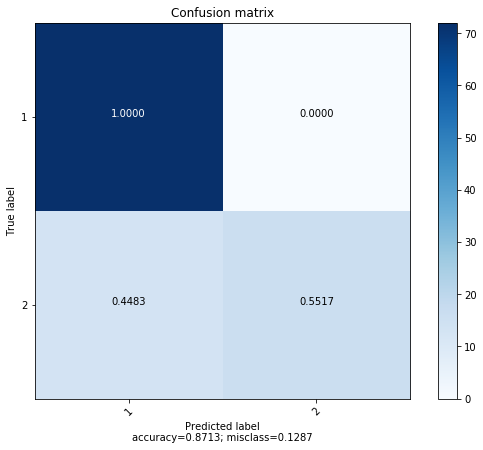

In [63]:
%matplotlib inline
from sklearn.metrics import confusion_matrix

labels = [1, 2]
random_forest_cm = confusion_matrix(y_test, y_pred_random_forest, labels)

    
plot_confusion_matrix(random_forest_cm, labels)

Classification isn't so good.  Some possible explanations:

* The cutoffs for toxicity classes 1 and 2 are dictated by the Mycocystin levels and are given by the EPA. 